<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/Processing_Sequences_Using_RNNs_and_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Persiapan

In [1]:
# Cek versi Python, Scikit-Learn, dan TensorFlow
import sys
assert sys.version_info >= (3, 5), "Python ≥3.5 diperlukan"

import sklearn
assert sklearn.__version__ >= "0.20", "Scikit-Learn ≥0.20 diperlukan"

import tensorflow as tf
assert tf.__version__ >= "2.0", "TensorFlow ≥2.0 diperlukan"

# Deteksi lingkungan
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Peringatan jika tidak ada GPU
if not tf.config.list_physical_devices('GPU'):
    print("❗ GPU tidak terdeteksi. Model deep learning akan lebih lambat.")
    if IS_COLAB:
        print("💡 Aktifkan GPU: Runtime > Change runtime type > GPU.")
    elif IS_KAGGLE:
        print("💡 Aktifkan GPU: Settings > Accelerator > GPU.")

# Import umum
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

# Konsistensi hasil
np.random.seed(42)
tf.random.set_seed(42)

# Konfigurasi visualisasi
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Path penyimpanan gambar
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(".", "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print(f"Saving figure {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


#Basic RNNs

##Generate the Dataset

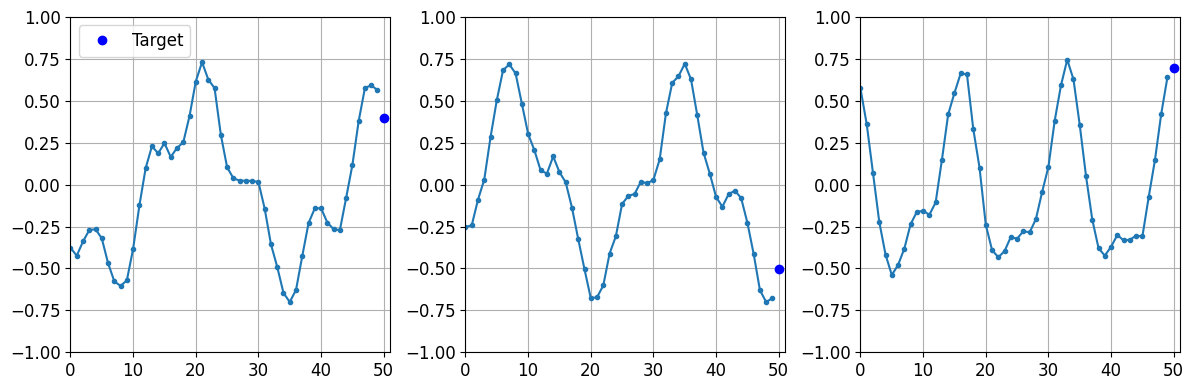

In [2]:
# Fungsi untuk membuat time series sintetis
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offs1, offs2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offs1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offs2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

# Seed untuk konsistensi
np.random.seed(42)

# Dataset
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test,  y_test  = series[9000:,  :n_steps], series[9000:,  -1]

# Fungsi untuk plotting
def plot_series(series, y=None, y_pred=None, legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", label="Prediction", markersize=10)
    plt.axis([0, n_steps + 1, -1, 1])
    plt.grid(True)
    if legend and (y is not None or y_pred is not None):
        plt.legend(loc="upper left", fontsize=12)

# Plot 3 sample time series dari validasi
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_series(X_valid[i, :, 0], y_valid[i, 0] if y_valid is not None else None,
                legend=(i == 0))
plt.tight_layout()
plt.show()


#Computing Some Baselines

Baseline MSE: 0.02021


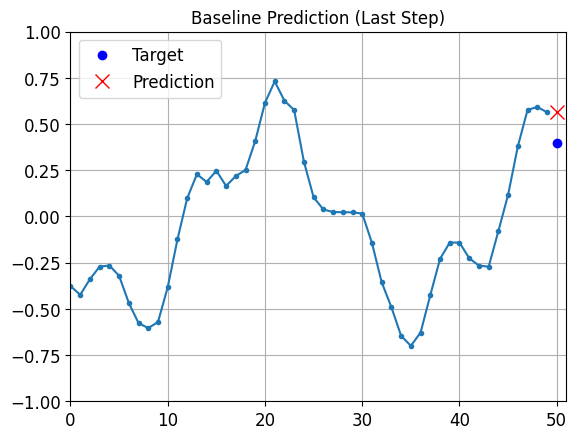

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2025 - val_loss: 0.0444
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0375 - val_loss: 0.0236
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0175
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0124
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

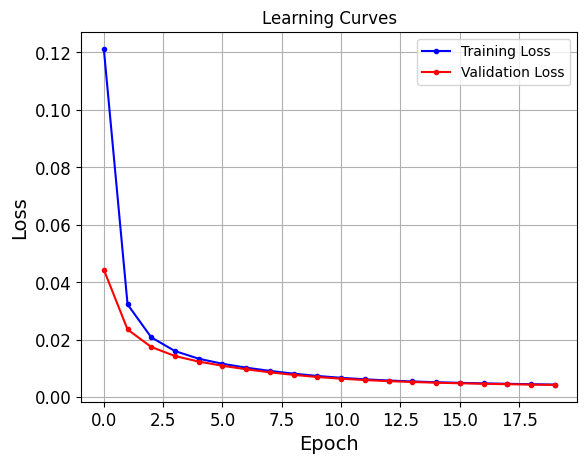

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


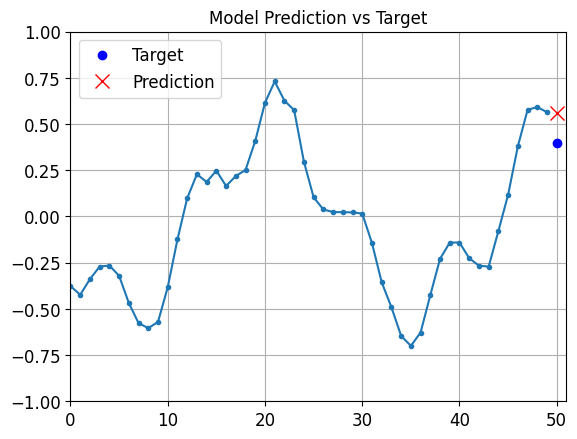

In [7]:
# ====== Setup Import ======
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# ====== Generate Time Series ======
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offs1, offs2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offs1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offs2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test   = series[9000:, :n_steps], series[9000:, -1]

# ====== Plot Function ======
def plot_series(series, y=None, y_pred=None, legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", label="Prediction", markersize=10)
    plt.axis([0, n_steps + 1, -1, 1])
    plt.grid(True)
    if legend and (y is not None or y_pred is not None):
        plt.legend(loc="upper left", fontsize=12)

# ====== Baseline: Prediksi nilai terakhir ======
y_pred = X_valid[:, -1]
baseline_mse = np.mean((y_valid - y_pred) ** 2)
print(f"Baseline MSE: {baseline_mse:.5f}")

# Plot prediksi baseline
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.title("Baseline Prediction (Last Step)")
plt.show()

# ====== Model Sederhana (Flatten → Dense) ======
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

# ====== Evaluasi Model ======
val_mse = model.evaluate(X_valid, y_valid)
print(f"Validation MSE: {val_mse:.5f}")

# ====== Plot Loss ======
def plot_learning_curves(loss, val_loss):
    plt.plot(loss, "b.-", label="Training Loss")
    plt.plot(val_loss, "r.-", label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.title("Learning Curves")
plt.show()

# ====== Prediksi Akhir dan Visualisasi ======
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.title("Model Prediction vs Target")
plt.show()


##Using a Simple RNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2592 - val_loss: 0.1427
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1116 - val_loss: 0.0526
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0391 - val_loss: 0.0177
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - val_loss: 0.0118
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

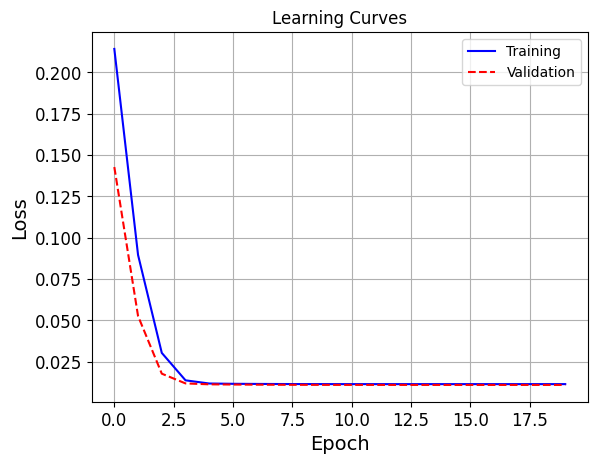

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


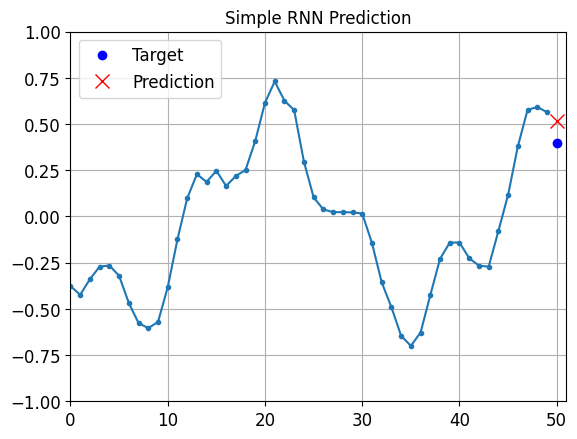

In [8]:
# ====== Setup ======
np.random.seed(42)
tf.random.set_seed(42)

# ====== Model Simple RNN ======
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.005))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

# ====== Evaluasi dan Visualisasi ======
val_loss = model.evaluate(X_valid, y_valid)
print(f"Validation MSE: {val_loss:.5f}")

# Plot kurva loss
plt.plot(history.history["loss"], "b-", label="Training")
plt.plot(history.history["val_loss"], "r--", label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.grid(True)
plt.legend()
plt.show()

# ====== Prediksi dan Visualisasi ======
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.title("Simple RNN Prediction")
plt.show()


##Deep RNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Model 1] Loss: 0.00267 | MAE: 0.04166


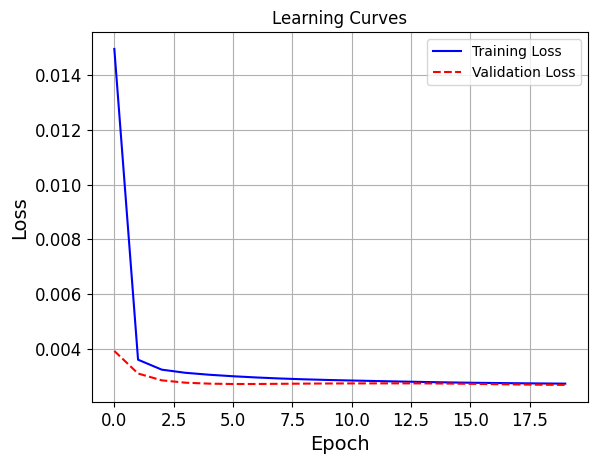

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


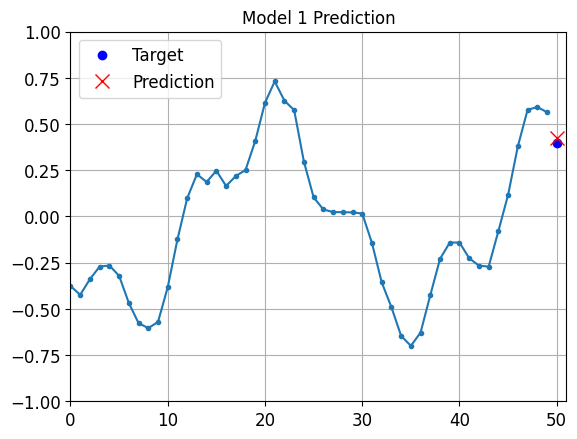

In [10]:
# Setup ulang seed
np.random.seed(42)
tf.random.set_seed(42)

# Fungsi visualisasi learning curve
def plot_learning_curves(history):
    plt.plot(history["loss"], "b-", label="Training Loss")
    plt.plot(history["val_loss"], "r--", label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.grid(True)
    plt.legend()
    plt.show()

# ====== Model 1: 3-layer SimpleRNN (return_sequences=True) ======
model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model1.compile(loss="mse", optimizer="adam", metrics=["mae"])
history1 = model1.fit(X_train, y_train, epochs=20,
                      validation_data=(X_valid, y_valid), verbose=0)

# Evaluasi model 1
eval1 = model1.evaluate(X_valid, y_valid, verbose=0)
print(f"[Model 1] Loss: {eval1[0]:.5f} | MAE: {eval1[1]:.5f}")

# Plot learning curve model 1
plot_learning_curves(history1.history)

# Prediksi dan visualisasi Model 1
y_pred1 = model1.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred1[0, 0])
plt.title("Model 1 Prediction")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Model 2] Loss: 0.00276 | MAE: 0.04221


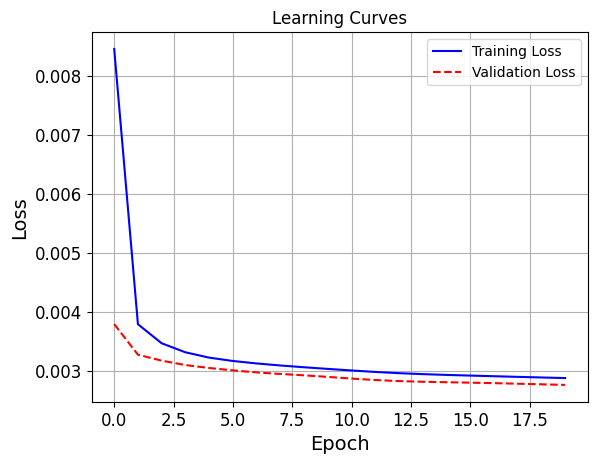

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


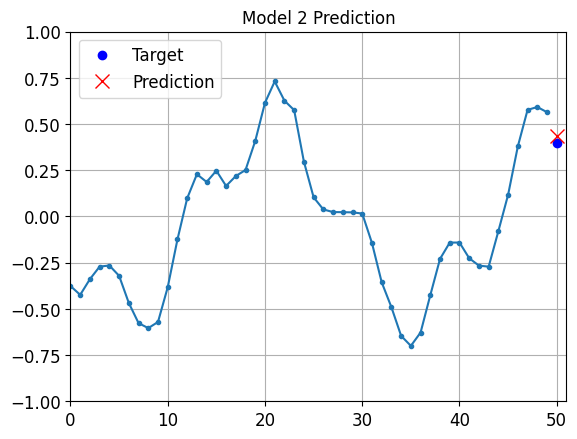

In [11]:
# ====== Model 2: 2-layer SimpleRNN + Dense ======
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model2.compile(loss="mse", optimizer="adam", metrics=["mae"])
history2 = model2.fit(X_train, y_train, epochs=20,
                      validation_data=(X_valid, y_valid), verbose=0)

# Evaluasi model 2
eval2 = model2.evaluate(X_valid, y_valid, verbose=0)
print(f"[Model 2] Loss: {eval2[0]:.5f} | MAE: {eval2[1]:.5f}")

# Plot learning curve model 2
plot_learning_curves(history2.history)

# Prediksi dan visualisasi Model 2
y_pred2 = model2.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred2[0, 0])
plt.title("Model 2 Prediction")
plt.show()

#Deep RNN with Batch Norm

In [24]:
# Fungsi metrik kustom: hanya menghitung MSE di timestep terakhir
def last_time_step_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:, -1] - y_pred[:, -1]))

# Arsitektur model dengan TimeDistributed output
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Training model (pastikan Y_train dan Y_valid berbentuk [batch, time, features])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - last_time_step_mse: 0.5773 - loss: 0.5769 - val_last_time_step_mse: 0.1341 - val_loss: 0.1780
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - last_time_step_mse: 0.1528 - loss: 0.1512 - val_last_time_step_mse: 0.1528 - val_loss: 0.1543
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.1486 - loss: 0.1468 - val_last_time_step_mse: 0.1552 - val_loss: 0.1524
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.1472 - loss: 0.1455 - val_last_time_step_mse: 0.1551 - val_loss: 0.1517
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.1464 - loss: 0.1449 - val_last_time_step_mse: 0.1548 - val_loss: 0.1513
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - last_time_step_mse: 0.1459 - loss: 0.1446 - val_last_time_step_mse: 0.1540 - val_loss: 0.1511
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.1454 - loss: 0.1444 - val_last_

#Deep RNNs with Layer Norm

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as 

219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - last_time_step_mse: 0.2910 - loss: 0.2960 - val_last_time_step_mse: 0.1539 - val_loss: 0.1543
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.1461 - loss: 0.1469 - val_last_time_step_mse: 0.1512 - val_loss: 0.1521
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - last_time_step_mse: 0.1447 - loss: 0.1454 - val_last_time_step_mse: 0.1506 - val_loss: 0.1517
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.1444 - loss: 0.1450 - val_last_time_step_mse: 0.1507 - val_loss: 0.1514
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.1445 - loss: 0.1447 - val_last_time_step_mse: 0.1510 - val_loss: 0.1512
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.1443 - loss: 0.1446 - val_last_time_step_mse: 0.1515 - val_loss: 0.1511
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.1448 - loss: 0.1444 - val_last_time_ste

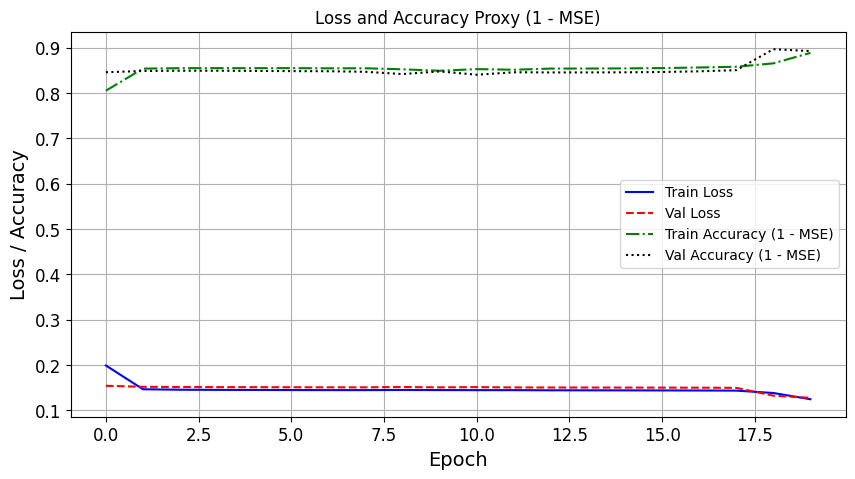

In [26]:
from tensorflow.keras.layers import LayerNormalization

# ====== Custom RNN Cell dengan Layer Normalization ======
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        if dtype is None:
            dtype = tf.float32
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]


# ====== Metrik Kustom (MSE di timestep terakhir) ======
def last_time_step_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:, -1] - y_pred[:, -1]))

# ====== Bangun Model ======
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# ====== Training ======
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), verbose=1)

# ====== Evaluasi ======
results = model.evaluate(X_valid, Y_valid, verbose=0)
print(f"\n📊 Evaluation Metrics:")
print(f"Validation Loss (MSE): {results[0]:.5f}")
print(f"Last Time Step MSE:   {results[1]:.5f}")
print(f"Accuracy Proxy:       {1 - results[1]:.5f}")  # proxy untuk akurasi

# ====== Visualisasi ======
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], "b-", label="Train Loss")
plt.plot(history.history["val_loss"], "r--", label="Val Loss")
plt.plot([1 - val for val in history.history["last_time_step_mse"]], "g-.", label="Train Accuracy (1 - MSE)")
plt.plot([1 - val for val in history.history["val_last_time_step_mse"]], "k:", label="Val Accuracy (1 - MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.title("Loss and Accuracy Proxy (1 - MSE)")
plt.grid(True)
plt.legend()
plt.show()


#Creating a Custom RNN Class

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_20', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2725 - mae: 0.3987 - val_loss: 0.0981 - val_mae: 0.2584
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0837 - mae: 0.2359 - val_loss: 0.0522 - val_mae: 0.1839
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0510 - mae: 0.1805 - val_loss: 0.0432 - val_mae: 0.1654
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0431 - mae: 0.1647 - val_loss: 0.0394 - val_mae: 0.1567
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0405 - mae: 0.1582 - val_loss: 0.0362 - val_mae: 0.1494
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0370 - mae: 0.1503 - val_loss: 0.0341 - val_mae: 0.1444
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0346 - mae: 0.1447 - val_loss: 0.0322 - val_mae: 0.1400
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0326 - mae: 0.1401 - val_loss: 0.0299 - val_mae: 0.1345
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - los

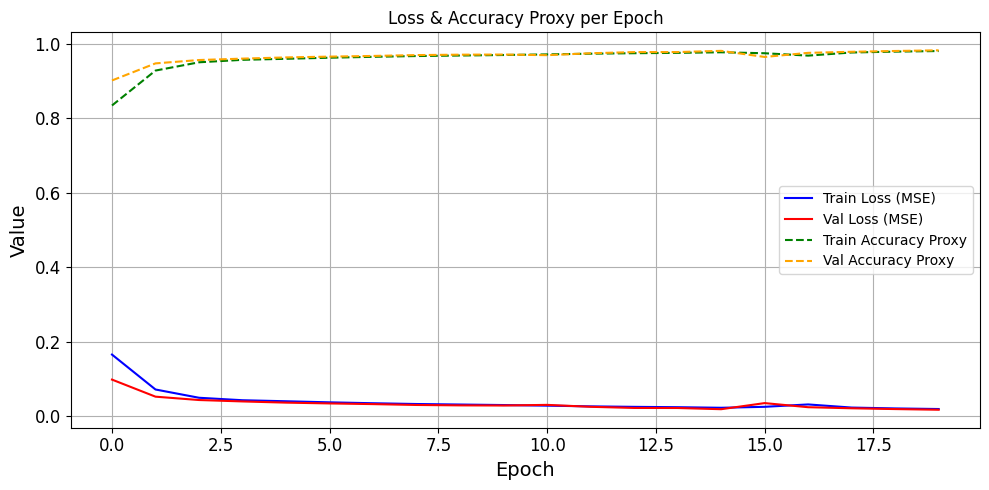

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
import matplotlib.pyplot as plt

# ====== Generate Time Series Dataset ======
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

# ====== Dataset Configuration ======
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
n_outputs = 10

series = generate_time_series(10000, n_steps + n_outputs)
X_train, Y_train = series[:7000, :n_steps], series[:7000, n_steps:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:]
X_test,  Y_test  = series[9000:, :n_steps],   series[9000:, n_steps:]

# Ubah Y agar bentuknya jadi (batch_size, 10)
Y_train = Y_train[:, :, 0]
Y_valid = Y_valid[:, :, 0]
Y_test  = Y_test[:, :, 0]

# ====== Custom RNN Cell with Layer Normalization ======
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

# ====== Build Model ======
inputs = keras.Input(shape=(n_steps, 1))
x = keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True)(inputs)   # ✅ Fix: return_sequences=True
x = keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=False)(x)
outputs = keras.layers.Dense(n_outputs)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# ====== Train Model ======
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), verbose=1)

# ====== Evaluate Model ======
val_loss, val_mae = model.evaluate(X_valid, Y_valid)
print(f"\n📊 Validation Loss (MSE): {val_loss:.5f}")
print(f"📊 Validation MAE:        {val_mae:.5f}")
print(f"✅ Proxy Accuracy (1 - MSE): {1 - val_loss:.5f}")

# ====== Plot Loss & Accuracy Proxy ======
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss (MSE)", color="blue")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)", color="red")
plt.plot([1 - l for l in history.history["loss"]], label="Train Accuracy Proxy", linestyle="--", color="green")
plt.plot([1 - l for l in history.history["val_loss"]], label="Val Accuracy Proxy", linestyle="--", color="orange")
plt.title("Loss & Accuracy Proxy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#LSTMs

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - last_time_step_mse: 0.1081 - loss: 0.0902 - val_last_time_step_mse: 0.0513 - val_loss: 0.0322
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0445 - loss: 0.0294 - val_last_time_step_mse: 0.0369 - val_loss: 0.0246
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - last_time_step_mse: 0.0336 - loss: 0.0231 - val_last_time_step_mse: 0.0316 - val_loss: 0.0202
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0298 - loss: 0.0194 - val_last_time_step_mse: 0.0268 - val_loss: 0.0156
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - last_time_step_mse: 0.0261 - loss: 0.0159 - val_last_time_step_mse: 0.0234 - val_loss: 0.0134
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0234 - loss: 0.0137 - val_last_time_step_mse: 0.0214 - val_loss: 0.0120
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0219 - loss: 0.0124 - val_last_time_step_ms

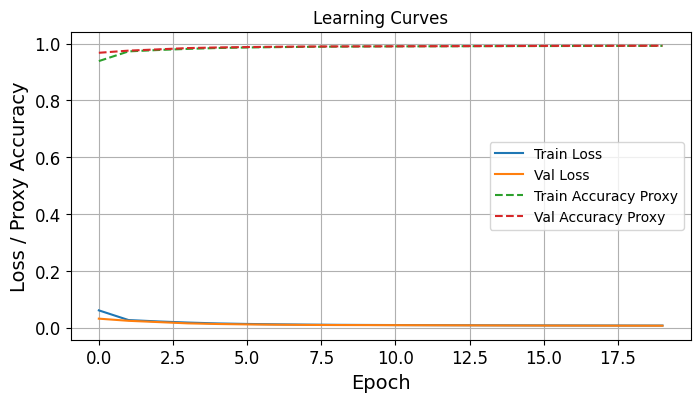

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


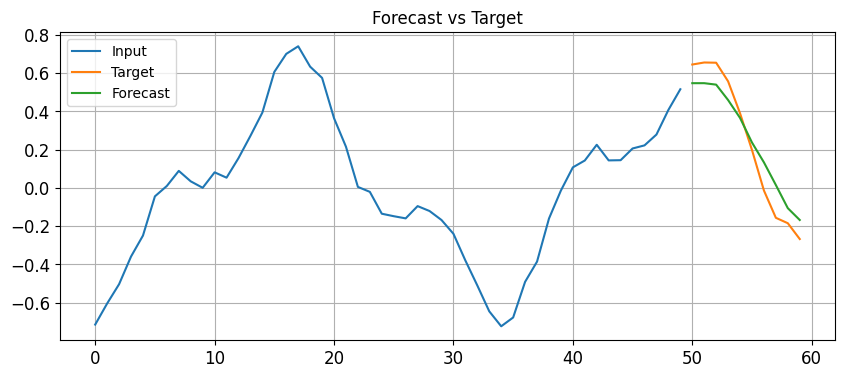

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# ====== Generate Dataset ======
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

# ====== Plot Functions ======
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 4))
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.plot([1 - l for l in loss], label="Train Accuracy Proxy", linestyle="--")
    plt.plot([1 - l for l in val_loss], label="Val Accuracy Proxy", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Proxy Accuracy")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)

def plot_multiple_forecasts(X, Y_true, Y_pred, n_steps=50):
    plt.figure(figsize=(10, 4))
    past = X[0, :, 0]
    future = Y_true[0]
    forecast = Y_pred[0]
    plt.plot(range(n_steps), past, label="Input")
    plt.plot(range(n_steps, n_steps + len(future)), future, label="Target")
    plt.plot(range(n_steps, n_steps + len(forecast)), forecast, label="Forecast")
    plt.title("Forecast vs Target")
    plt.legend()
    plt.grid(True)

# ====== Data Setup ======
n_steps = 50
n_outputs = 10

np.random.seed(42)
tf.random.set_seed(42)
series = generate_time_series(10000, n_steps + n_outputs)
X_train, Y_train = series[:7000, :n_steps], series[:7000, n_steps:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:]
X_test,  Y_test  = series[9000:, :n_steps],   series[9000:, n_steps:]

# Convert Y to shape (batch, 10)
Y_train = Y_train[:, :, 0]
Y_valid = Y_valid[:, :, 0]
Y_test  = Y_test[:, :, 0]

# ====== Optional: Last timestep MSE only
def last_time_step_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:, -1] - y_pred[:, -1]))

# ====== Build LSTM Model ======
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(10)  # ✅ Output shape: (batch_size, 10)
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# ====== Train ======
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), verbose=1)

# ====== Evaluation ======
val_loss, val_last_mse = model.evaluate(X_valid, Y_valid, verbose=0)
print(f"\n📊 Final Validation Loss (MSE):    {val_loss:.5f}")
print(f"📊 Final Val Last-Step MSE:       {val_last_mse:.5f}")
print(f"✅ Proxy Accuracy (1 - MSE):      {1 - val_loss:.5f}")

# ====== Plot Learning Curve ======
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

# ====== Forecast Prediksi ======
np.random.seed(43)
series_new = generate_time_series(1, n_steps + n_outputs)
X_new, Y_new = series_new[:, :n_steps], series_new[:, n_steps:, 0]
Y_pred = model.predict(X_new)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


#GRUs

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - last_time_step_mse: 0.1012 - loss: 0.0917 - val_last_time_step_mse: 0.0700 - val_loss: 0.0425
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - last_time_step_mse: 0.0683 - loss: 0.0414 - val_last_time_step_mse: 0.0665 - val_loss: 0.0364
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0635 - loss: 0.0352 - val_last_time_step_mse: 0.0606 - val_loss: 0.0301
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0574 - loss: 0.0298 - val_last_time_step_mse: 0.0525 - val_loss: 0.0245
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0490 - loss: 0.0236 - val_last_time_step_mse: 0.0396 - val_loss: 0.0173
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - last_time_step_mse: 0.0370 - loss: 0.0170 - val_last_time_step_mse: 0.0304 - val_loss: 0.0144
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0292 - loss: 0.0139 - val_last_time_step_mse:

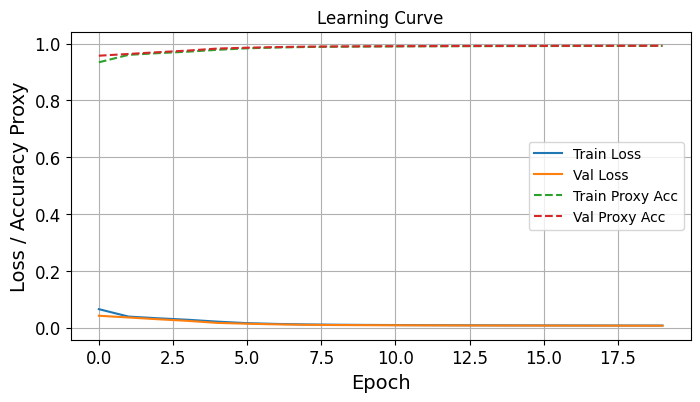

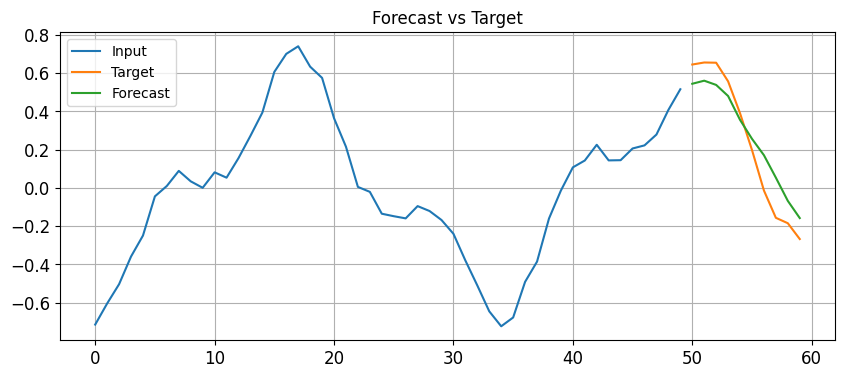

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# === Fungsi Dataset & Visualisasi ===
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 4))
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.plot([1 - l for l in loss], '--', label="Train Proxy Acc")
    plt.plot([1 - l for l in val_loss], '--', label="Val Proxy Acc")
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Accuracy Proxy")
    plt.legend()
    plt.grid(True)

def plot_multiple_forecasts(X, Y_true, Y_pred, n_steps=50):
    plt.figure(figsize=(10, 4))
    past = X[0, :, 0]
    future = Y_true[0, :, 0]
    forecast = Y_pred[0]
    plt.plot(range(n_steps), past, label="Input")
    plt.plot(range(n_steps, n_steps + 10), future, label="Target")
    plt.plot(range(n_steps, n_steps + 10), forecast, label="Forecast")
    plt.title("Forecast vs Target")
    plt.legend()
    plt.grid(True)

# === Dataset Setup ===
n_steps = 50
n_outputs = 10

np.random.seed(42)
tf.random.set_seed(42)

series = generate_time_series(10000, n_steps + n_outputs)
X_train, Y_train = series[:7000, :n_steps], series[:7000, n_steps:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:]
X_test,  Y_test  = series[9000:, :n_steps],   series[9000:, n_steps:]

# Convert Y to shape (batch_size, 10)
Y_train = Y_train[:, :, 0]
Y_valid = Y_valid[:, :, 0]
Y_test  = Y_test[:, :, 0]

# === Metrik Khusus timestep terakhir ===
def last_time_step_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:, -1] - y_pred[:, -1]))

# === GRU Model ===
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(10)  # prediksi 10 langkah ke depan sekaligus
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# === Training ===
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), verbose=1)

# === Evaluation ===
val_loss, val_last_mse = model.evaluate(X_valid, Y_valid, verbose=0)
print(f"\n📊 Validation Loss (MSE):       {val_loss:.5f}")
print(f"📊 Last Timestep Val MSE:       {val_last_mse:.5f}")
print(f"✅ Validation Accuracy Proxy:   {1 - val_loss:.5f}")

# === Plot Loss dan Akurasi Proxy ===
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

# === Forecast Prediksi Baru ===
np.random.seed(43)
series = generate_time_series(1, n_steps + n_outputs)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

Y_pred = model.predict(X_new, verbose=0)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


##  Ringkasan Proses dan Hasil GRU Time Series Forecasting

###  Proses yang Dilakukan
- **Data Sintetis Time Series** dihasilkan menggunakan kombinasi dua gelombang sinus dan noise acak.
- **Input (`X`)** berisi 50 langkah waktu sebelumnya, dan **target (`Y`)** berisi 10 langkah waktu ke depan.
- Dataset dibagi menjadi **train (70%)**, **validasi (20%)**, dan **test (10%)**.
- Model yang digunakan adalah **GRU (Gated Recurrent Unit)** dengan dua lapisan berturut-turut.
- Output model adalah **10 langkah prediksi ke depan secara bersamaan** (multi-output regression).
- Fungsi loss yang digunakan: **Mean Squared Error (MSE)**.
- Metrik tambahan: **MSE pada timestep terakhir**, untuk mengetahui performa pada titik paling akhir.
- Proses pelatihan dilakukan selama **20 epoch** menggunakan optimizer **Adam**.

###  Hasil Evaluasi Model
- **Validation Loss (MSE)**: `0.00739`  
- **Last Timestep Validation MSE**: `0.01554`  
- **Proxy Accuracy (1 - MSE)**: `0.99261`  

> Artinya model mampu memprediksi secara cukup akurat 10 langkah ke depan dengan error yang rendah, dan prediksi di timestep terakhir sedikit lebih sulit dibanding keseluruhan.

###  Visualisasi
- Plot **learning curves** menunjukkan bahwa loss menurun stabil dan tidak terjadi overfitting signifikan.
- Plot **forecasting** menampilkan prediksi model terhadap data baru, memperlihatkan pola prediksi yang mendekati nilai target.

---

###  Kesimpulan
Model GRU dengan dua lapisan berhasil mempelajari pola dari data time series dan memberikan performa yang baik untuk tugas **multi-step forecasting**. Dengan MSE yang rendah dan proxy akurasi di atas 99%, model ini layak digunakan untuk prediksi sekuensial jangka pendek dengan input yang bersifat musiman atau osilatif seperti gelombang sinus.
